# Camera Calibration Pipeline 
Insert the folder where the checkerboard markers are stored in the `data_folder`

## Open a video and pull the frames to put into a folder

In [1]:
import os
import cv2
from cv2 import aruco
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd

In [2]:
def select_frames(video_file, skip_frames=100, start_frame=0):
    """
    Allows the user to manually select frames from a video file for inspection and saving.

    Args:
        video_file (str): The path to the video file.
        skip_frames (int, optional): The number of frames to skip between selections. Defaults to 100.
        start_frame (int, optional): The starting frame index. Defaults to 0.

    Returns:
        None

    Displays each frame of the video file, allowing the user to inspect and save frames.
    Checkerboard patterns should have the entire board visible, without occlusions. 
    Aruco or Charuco boards should be in focus as possible. 
    Only full markers will be detected, but only a partial pattern need be visible.

    Controls:
        - Press 'S' to save the current frame.
        - Press 'A' to skip to the next frame.
        - Press 'Q' to quit the selection process.

    Saved frames will be stored in the 'Frames' directory alongside the video file.

    Note:
        This function uses OpenCV for video capture and frame manipulation.
    """
    
    cap = cv2.VideoCapture(video_file)
    if not cap.isOpened():
        print("Error: Could not open video file.")
        return
    
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    current_frame = start_frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
    print("Please inspect each frame. Checkerboard patterns should have the entire board visible, without occlusions. Aruco or Charuco boards should be in focus as possible. Only full markers will be detected, but only a partial pattern need be visible.")
    print("Press 'S' to save the frame, 'A' to try the next frame, or 'Q' to quit")

    while current_frame<frame_count:
        ret, frame = cap.read()
        if not ret:
            break
        
        cv2.namedWindow('Frame', cv2.WINDOW_NORMAL)  # Make the window resizable
        cv2.resizeWindow('Frame', 640, 480)
        cv2.imshow('Frame', frame)
        cv2.putText(frame, f'Frame: {current_frame}/{frame_count}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        key = cv2.waitKey(0)
        
        # Save on S
        if key == ord('s'):
            d = video_file.rsplit(sep='\\', maxsplit = 1)[0] + f'\\Frames\\frame_{current_frame}.jpg'
            cv2.imwrite(d, frame)
            print(f"Frame {current_frame} saved at {d}")
            current_frame += skip_frames
        # Move to the next frame on D
        elif key == ord('a'):
            current_frame += skip_frames

        # Exit on Q
        elif key == ord('q'):
            break

        cap.set(cv2.CAP_PROP_POS_FRAMES, current_frame)
    cap.release()
    cv2.destroyAllWindows()

# Cycle through frames of selected videos and 

Change the names of the saved video files and go through each one by one. Save several frames with full checkerboards in focus and at several angles. Optionally give the number of frames between viewed frames (skip_frames) and the first frame (start_frame). If it exists, selected frames are saved in the 'Frames' folder in the same directory as the movie.

In [ ]:
vidfile = r'C:\PhieldsCalibrationData\240408\Reproject_test\Camera2\240804_CalibrationAEON2_SNAP_camera2.avi'
select_frames(vidfile, skip_frames=1, start_frame=0)

### Calculate camera Intrinsic parameters 
Run calibrate camera from opencv using all the checkerboard points found on each image.
Create function to run through all images saved in a datafolder for chessboard calibration. Can save (optional) calibration values in a calibration.yml (save = True)

In [3]:
charuco_root = r"C:\PhieldsCalibrationData\Aeon2Calib\3DAcquisistion\2024-03-21T11-48-18\\"
chessboard_root = r"C:\PhieldsCalibrationData\Aeon2Calib\3DAcquisistion\2024-03-21T11-47-02\\"
######################################################################################
data_folder_camera1 = chessboard_root + r"Camera1\Frames\\"
data_folder_camera2 = chessboard_root + r"Camera2\Frames\\"
data_folder_camera3 = chessboard_root + r"Camera3\Frames\\"
######################################################################################
# charuco_data_folder_camera1 = charuco_root + r"Camera1\Frames\\"
# charuco_data_folder_camera2 = charuco_root + r"Camera2\Frames\\"
# charuco_data_folder_camera3 = charuco_root + r"Camera3\Frames\\"
######################################################################################

datafolders_chess = [data_folder_camera1,data_folder_camera2,data_folder_camera3]
# datafolders_charuco = [charuco_data_folder_camera1,charuco_data_folder_camera2,charuco_data_folder_camera3]

In [4]:
def ChessboardCalibrate(datafolder, patternsize = (14, 19), report = True, save = False):
    """
    Calibrates a camera using images of a chessboard pattern.

    Args:
        datafolder (str): The folder path containing images of the chessboard pattern.
        patternsize (tuple, optional): The dimensions of the chessboard pattern (rows, columns). Defaults to (14, 19).
        report (bool, optional): Whether to print calibration report. Defaults to True.
        save (bool, optional): Whether to save calibration data. Defaults to False.

    Returns:
        tuple: A tuple containing:
            - reproj_error (float): Reprojection error of the calibration.
            - intrinsics (numpy.ndarray): Camera intrinsic matrix.
            - distortion (numpy.ndarray): Distortion coefficients.
            - rvecs (list): Rotation vectors for each calibration image.
            - tvecs (list): Translation vectors for each calibration image.
            - imagePoints (list): Image coordinates of detected corners.
            - objectPoints (list): Object coordinates of detected corners.
            - fnames_chessboard_found (list): File names of images where the chessboard pattern was found (for undistorting).

    Calibrates a camera using images of a chessboard pattern. 
    Each image in the specified data folder is processed to detect the chessboard corners. 
    If the chessboard pattern is found, corresponding object points (3D) and image points (2D) are stored.
    The camera is then calibrated using the collected points.

    If 'report' is set to True, a calibration report including the reprojection error and principal points is printed.
    If 'save' is set to True, the calibration data is saved to a YAML file named 'Calibration.yml' in the datafolder.

    Note:
        This function uses OpenCV for camera calibration and image processing.
"""

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    pattern = np.zeros((1, patternsize[0] * patternsize[1], 3), np.float32)
    pattern[0,:,:2] = np.mgrid[0:patternsize[0], 0:patternsize[1]].T.reshape(-1, 2) * 0.001 # size of pattern in real world (m) to put objpoints into correct scale
    fnames = glob.glob(datafolder + '/*.jpg')
    fnames_chessboard_found = []
    objectPoints = []
    imagePoints = []

    for fname in fnames:
        if report:
            print("Processing {0}...".format(os.path.split(fname)[-1]), end=" ")
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        flags = cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE
        ret, corners = cv2.findChessboardCorners(gray, patternsize, flags)
        if ret:
            if report:
                print("Success")  
            fnames_chessboard_found.append(fname)
        else: 
            if report:
                print("Not found!")
        
        if ret:
            corners = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
            objectPoints.append(pattern)
            imagePoints.append(corners)
            
            img = cv2.drawChessboardCorners(img, patternsize, corners, ret)
        if report:
            plt.figure()
            plt.imshow(img)
            plt.draw()
    if report:
        print("Calibrating camera with {0} points from {1} images...".format(
            np.prod(np.array(imagePoints).shape) // 2,
            len(imagePoints)))
    reproj_error, intrinsics, distortion, rvecs, tvecs = cv2.calibrateCamera(objectPoints, imagePoints, gray.shape[::-1], None, None)

    if report:
        print(f"Reprojection error: {reproj_error}")
        print(f'Principle points: ({intrinsics[0,2]} / {img.shape[1]/2}) : {intrinsics[1,2]} / {img.shape[0]/2}')

    if save:
        sname = "{0}\\Calibration.yml".format(os.path.split(fname)[0])
        print("Writing calibration file {0}...".format(sname))
        flags = cv2.FILE_STORAGE_FORMAT_YAML + cv2.FILE_STORAGE_WRITE
        s = cv2.FileStorage(sname,flags)
        s.write('image_width', img.shape[1])
        s.write('image_height', img.shape[0])
        s.write('camera_matrix', intrinsics)
        s.write('distortion_coefficients', distortion)
        s.write('reprojection_error', reproj_error)
        s.release()

    return reproj_error, intrinsics, distortion, rvecs, tvecs, imagePoints, objectPoints, fnames_chessboard_found

In [5]:
def undistortChessboard(fnames,imagePoints,intrinsics, distortion, patternsize = (14, 19), report = True):
    for i,fname in enumerate(fnames):
        if report:
            print("Undistorting {0}...".format(os.path.split(fname)[-1]))
        img = cv2.imread(fname)
        img = cv2.drawChessboardCorners(img, patternsize, imagePoints[i], True)
    
        uimg = cv2.undistort(img, intrinsics, distortion)
        if i ==0 and report:
            plt.figure()
            plt.imshow(uimg)
            plt.draw()

## Now calibrate using chessboard markers. Loop through chessboard folders for each of the three cameras

Processing frame_0.jpg... Success
Processing frame_1000.jpg... Success
Processing frame_1050.jpg... Success
Processing frame_1200.jpg... Success
Processing frame_1250.jpg... Success
Processing frame_1300.jpg... Success
Processing frame_1350.jpg... Not found!
Processing frame_450.jpg... Success
Calibrating camera with 1862 points from 7 images...
Reprojection error: 0.15668826453364082
Principle points: (731.1369750694419 / 720.0) : 551.5241291987193 / 540.0
Processing frame_0.jpg... Not found!
Processing frame_1800.jpg... Success
Processing frame_1850.jpg... Success
Processing frame_1950.jpg... Success
Processing frame_650.jpg... Success
Calibrating camera with 1064 points from 4 images...
Reprojection error: 0.15330982608315138
Principle points: (719.723616060202 / 720.0) : 539.4188361542108 / 540.0
Processing frame_0.jpg... Success
Processing frame_1500.jpg... Success
Processing frame_1550.jpg... Success
Processing frame_1600.jpg... Success
Calibrating camera with 1064 points from 4 

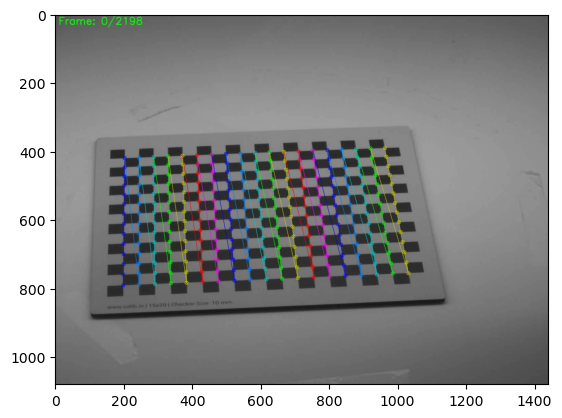

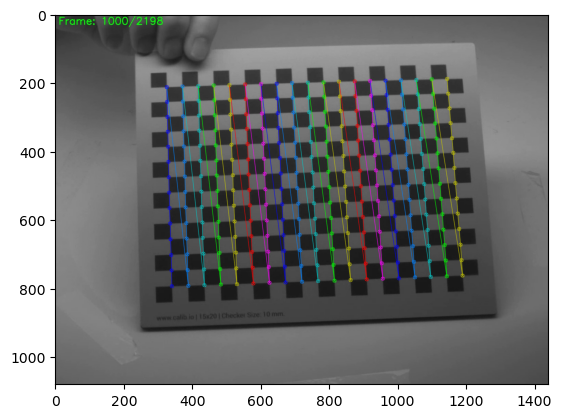

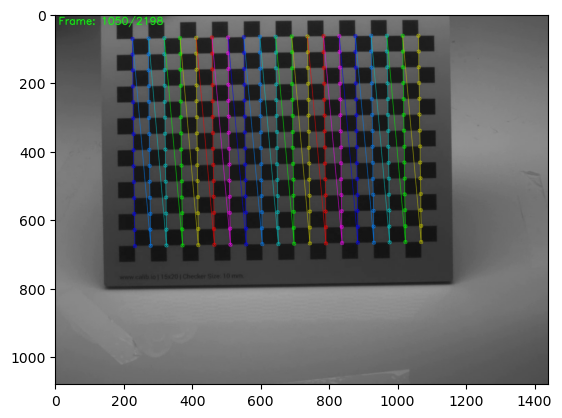

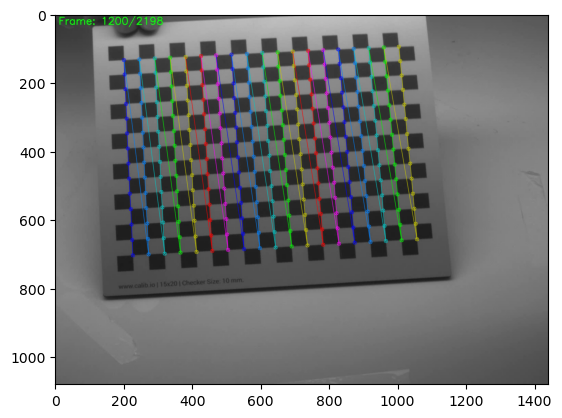

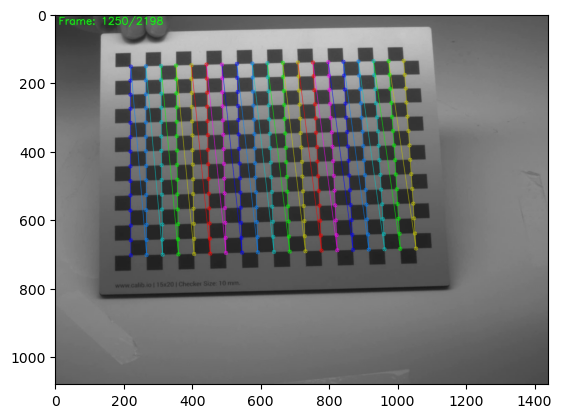

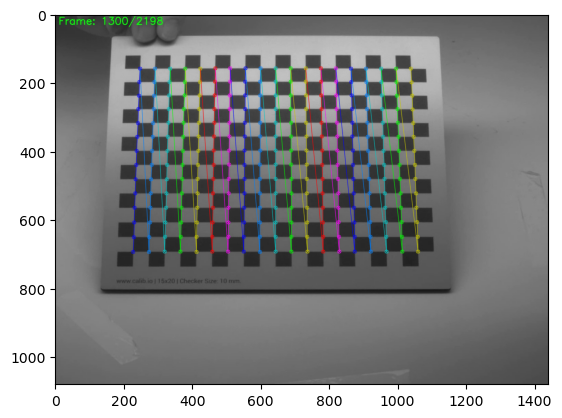

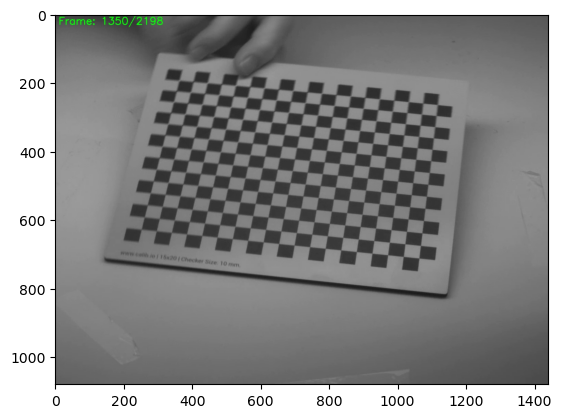

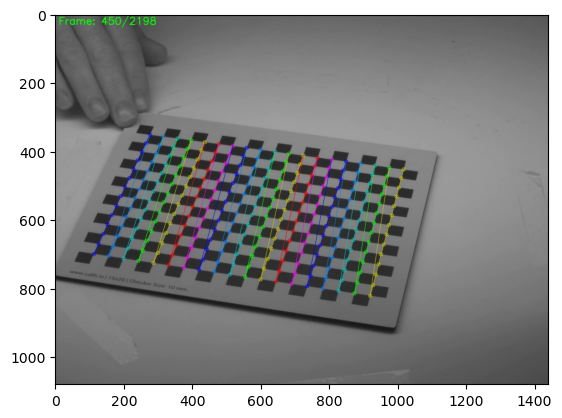

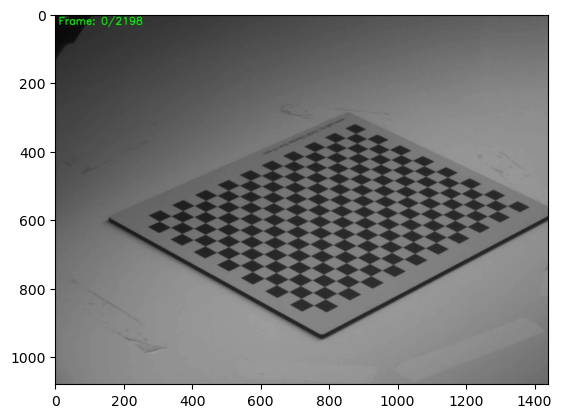

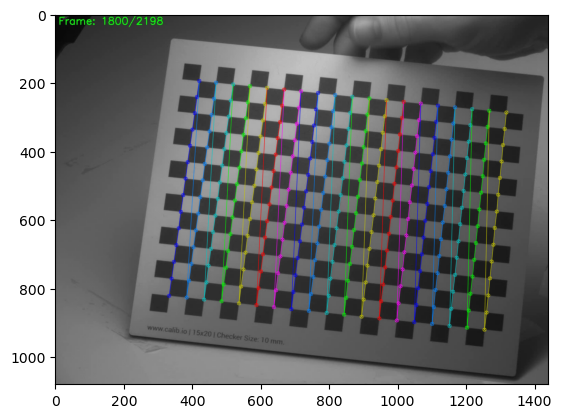

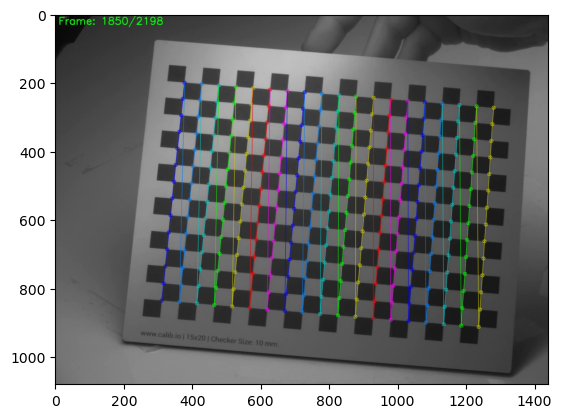

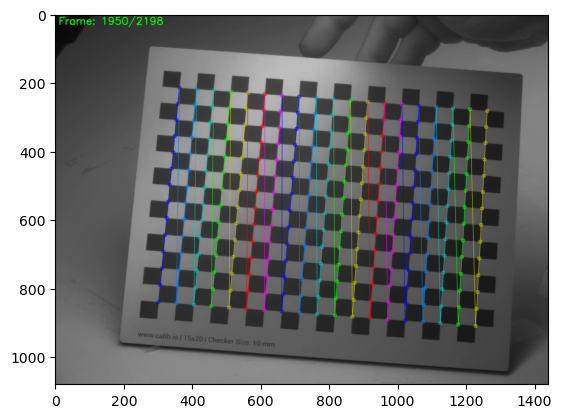

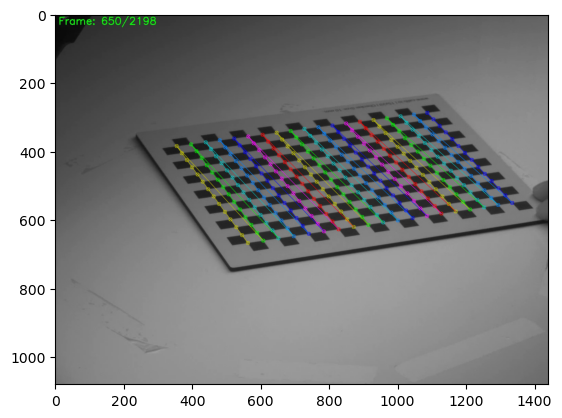

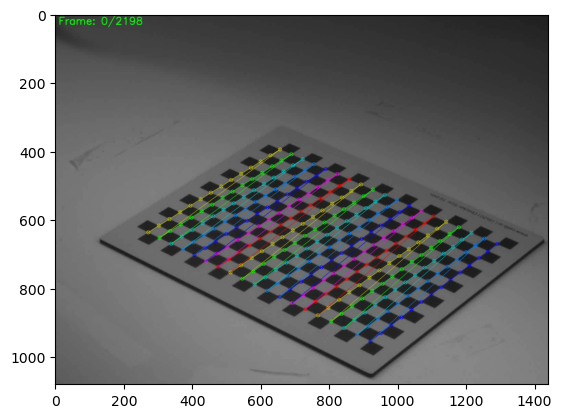

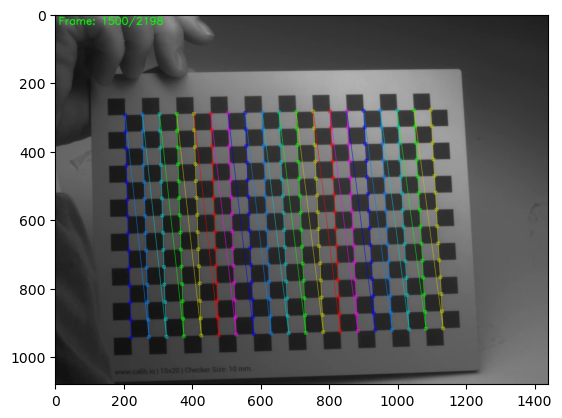

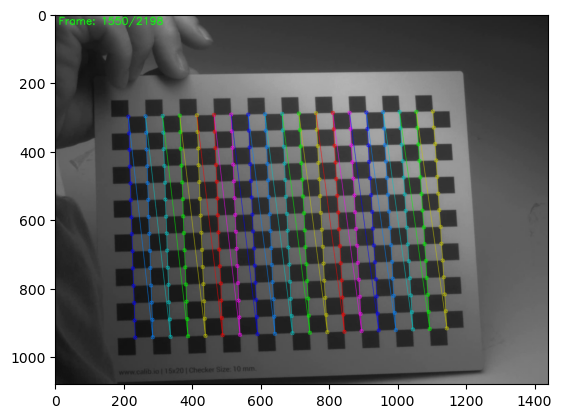

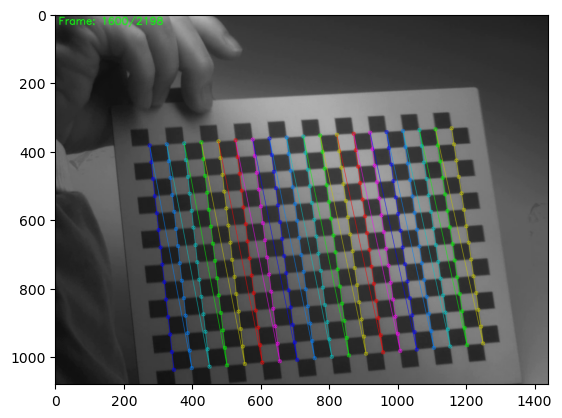

In [6]:
intrinsics_chess, distortions_chess = [], []
rvecsS, tvecsS = [],[]
rvecsS_charuco, tvecsS_charuco = [],[]
for datafolder in datafolders_chess:
    reproj_error, intrinsics, distortion, rvecs, tvecs, imagePoints, objectPoints, fnames = ChessboardCalibrate(datafolder, report = True, save = False)
    undistortChessboard(fnames,imagePoints,intrinsics, distortion, report = False)
    intrinsics_chess.append(intrinsics)
    distortions_chess.append(distortion)
    rvecsS.append(rvecs)
    tvecsS.append(tvecs)

# intrinsics_charuco, distortions_charuco = [], []
# for datafolder in datafolders_charuco:
#     reproj_error, intrinsics, distortion, rvecs, tvecs, imagePoints, objectPoints, fnames = ChessboardCalibrate(datafolder, report = False, save = False)
#     undistortChessboard(fnames,imagePoints,intrinsics, distortion, report = False)
#     intrinsics_charuco.append(intrinsics)
#     distortions_charuco.append(distortion)
#     rvecsS_charuco.append(rvecs)
#     tvecsS_charuco.append(tvecs)
# tvecsS

## Check parallel markers lie on a straight line

In [ ]:
from sklearn.linear_model import LinearRegression

ii = 2
points = imagePoints[0][ii*14:(ii*14)+14]
x = []
y = []
for point in points:
    x.append(point[0][0])
    y.append(point[0][1])
x=np.array(x)
y=np.array(y)
x = x.reshape(-1, 1)

model = LinearRegression()
model.fit(x, y)

r_squared = model.score(x, y)
r_squared

## Pose estimation for extrinsic parameter computation and validation with Aruco Markers

Uses a single view of a charuco or aruco board from multiple cameras to estimate the average cross - camera reprojection error. i.e. if i estimate where in camera 1 an aruco corner will be in camera 2, how accurate am I? This is averaged across all corners.

In [7]:
# Set ARUCO marker parameters
ARUCO_DICT = aruco.DICT_4X4_1000   # Dictionary ID
# ARUCO_DICT = aruco.DICT_ARUCO_ORIGINAL
SQUARES_VERTICALLY = 20             # Number of squares vertically
SQUARES_HORIZONTALLY = 15             # Number of squares horizontally
SQUARE_LENGTH = 10                   # Square side length (in pixels)
MARKER_LENGTH = 7                   # ArUco marker side length (in pixels)
MARGIN_PX = 20                       # Margins size (in pixels)                    # Margins size (in pixels)
dictionary = cv2.aruco.getPredefinedDictionary(ARUCO_DICT)
board = cv2.aruco.CharucoBoard((SQUARES_VERTICALLY, SQUARES_HORIZONTALLY), SQUARE_LENGTH, MARKER_LENGTH, dictionary)

In [8]:
def get_marker_corners(datafolder, intrinsics, distortion, interpolate=False, report=True):
    """
    Detects marker corners in images and extracts Charuco board corners and IDs.

    Args:
        datafolder (str): The folder path containing images.
        intrinsics (numpy.ndarray): Camera intrinsic matrix.
        distortion (numpy.ndarray): Distortion coefficients.
        interpolate (bool, optional): Whether to interpolate Charuco corners. Defaults to False.
        report (bool, optional): Whether to print progress messages. Defaults to True.

    Returns:
        tuple: A tuple containing:
            - corners (list): Detected marker corners for each image.
            - ids (list): Detected marker IDs for each image.
            - charuco_corners (list): Interpolated Charuco board corners for each image.
            - charuco_ids (list): Interpolated Charuco board IDs for each image.
            - image_files (list): File paths of the processed images.

    Detects marker corners in images using the ArUco detector.
    Extracts Charuco board corners and IDs using detected marker corners and IDs.
    Optionally, interpolates Charuco corners.

    Note:
        This function uses OpenCV for marker detection and Charuco corner interpolation.
    """
    # Define the aruco dictionary, charuco board and detector
    dictionary = cv2.aruco.getPredefinedDictionary(ARUCO_DICT)
    board = cv2.aruco.CharucoBoard((SQUARES_VERTICALLY, SQUARES_HORIZONTALLY), SQUARE_LENGTH, MARKER_LENGTH, dictionary)
    params = cv2.aruco.DetectorParameters()
    detector = cv2.aruco.ArucoDetector(dictionary, params)
    
    # Load images from directory
    image_files = [os.path.join(datafolder, f) for f in os.listdir(datafolder) if f.endswith(".jpg")]
    all_charuco_ids = []
    all_charuco_corners = []
    corners, ids =[],[]
    charuco_corners = []
    charuco_ids = []
    
    # Define a color map using matplotlib
    cmap = plt.get_cmap('tab20')
    colors = [cmap(i) for i in range(20)]  # Extract 20 colors from the tab20 colormap
    
    ret_images = []
    # Loop over images and find corners
    for image_file in image_files:
        image = cv2.imread(image_file)
        image_copy = image.copy()
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        ret_images.append(image_copy)
        # Undistort the image
        image_undistorted = cv2.undistort(image, intrinsics, distortion)
        
        imgSize = image.shape
        marker_corners, marker_ids, _ = detector.detectMarkers(image_undistorted)
        corners.append(marker_corners)
        ids.append(marker_ids)
        
        if len(marker_ids) > 0: # If at least one marker is detected
            if report:
                for i, marker in enumerate(marker_corners):
                    # Draw each marker corner with a color from the colormap
                    for j, corner in enumerate(marker[0]):
                        corner = (int(corner[0]), int(corner[1])) # convert to integer so we can use them as points
                        color = tuple(int(c * 255) for c in colors[j % len(colors)])  # Convert to 0-255 range
                        cv2.circle(image_copy, corner, 5, color, -1)
                plt.figure()
                plt.imshow(cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB), cmap=None)
                plt.title(image_file)
                plt.axis('off')
                plt.show()
                
            if interpolate:
                ret, charucoCorners, charucoIds = cv2.aruco.interpolateCornersCharuco(marker_corners, marker_ids, image_undistorted, board)

                if marker_ids is not None and charucoCorners is not None and len(charucoCorners) > 0:
                    charuco_corners.append(charucoCorners)
                    charuco_ids.append(charucoIds)
                else:
                    print('Error interpolating Charuco corners.')
        
    return corners, ids, charuco_corners, charuco_ids, ret_images


# Collect extrinsic parameters for each camera

Find Aruco markers in the field of view for each camera

In [13]:
reproj_root = r'C:\PhieldsCalibrationData\240514\Reproject_test\\'
reproj_folders = [reproj_root + r'Camera1\Frames\\',
                  reproj_root + r'Camera2\Frames\\',
                  reproj_root + r'Camera3\Frames\\']

Create dataframes for each camera's marker corners. Merge these then exclude any that don't appear in all 3 cameras. 

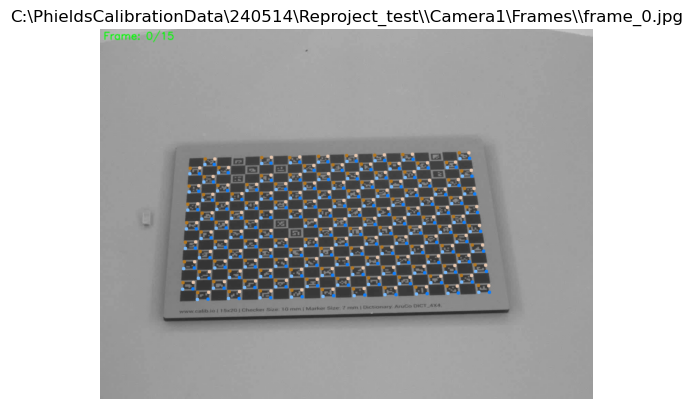

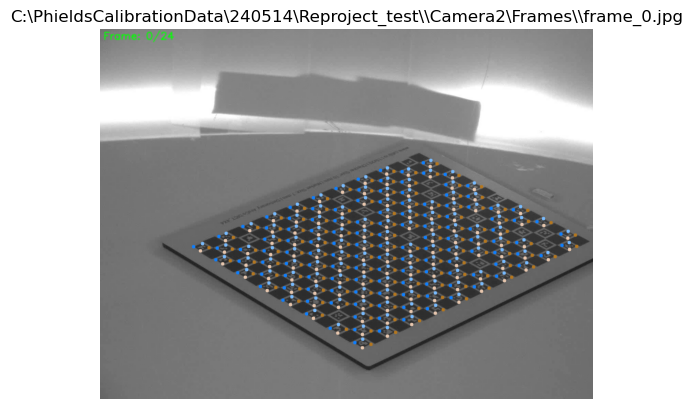

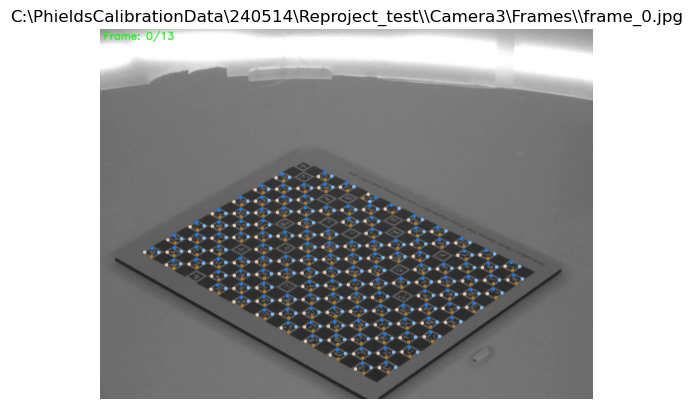

,Marker_ID,Corner_1_x_Camera1,Corner_1_y_Camera1,Corner_2_x_Camera1,Corner_2_y_Camera1,Corner_3_x_Camera1,Corner_3_y_Camera1,Corner_4_x_Camera1,Corner_4_y_Camera1,Corner_1_x_Camera2,...,Corner_4_x_Camera2,Corner_4_y_Camera2,Corner_1_x_Camera3,Corner_1_y_Camera3,Corner_2_x_Camera3,Corner_2_y_Camera3,Corner_3_x_Camera3,Corner_3_y_Camera3,Corner_4_x_Camera3,Corner_4_y_Camera3
0,0,307.0,379.0,335.0,379.0,333.0,395.0,306.0,395.0,1392.0,...,1370.0,623.0,770.0,1004.0,746.0,992.0,766.0,976.0,791.0,988.0
1,2,472.0,375.0,500.0,374.0,499.0,391.0,472.0,392.0,1266.0,...,1246.0,682.0,623.0,923.0,600.0,911.0,620.0,896.0,644.0,908.0
2,3,554.0,375.0,583.0,373.0,583.0,388.0,556.0,390.0,1202.0,...,1180.0,712.0,551.0,884.0,529.0,872.0,549.0,858.0,572.0,869.0
3,4,638.0,371.0,665.0,371.0,665.0,387.0,638.0,388.0,1136.0,...,1115.0,743.0,482.0,845.0,459.0,834.0,480.0,820.0,503.0,832.0
4,5,720.0,369.0,747.0,369.0,748.0,385.0,721.0,386.0,1070.0,...,1048.0,774.0,415.0,807.0,391.0,796.0,412.0,783.0,433.0,794.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,143,560.0,762.0,589.0,761.0,590.0,781.0,559.0,782.0,730.0,...,710.0,457.0,992.0,600.0,969.0,591.0,986.0,579.0,1010.0,589.0
107,144,649.0,760.0,680.0,759.0,682.0,778.0,651.0,780.0,664.0,...,645.0,484.0,922.0,567.0,901.0,557.0,917.0,546.0,941.0,556.0
108,145,740.0,758.0,771.0,757.0,773.0,776.0,742.0,778.0,597.0,...,576.0,511.0,855.0,535.0,833.0,525.0,850.0,514.0,873.0,523.0
109,147,922.0,753.0,953.0,752.0,955.0,772.0,924.0,773.0,460.0,...,441.0,568.0,723.0,471.0,702.0,461.0,718.0,451.0,741.0,460.0


In [14]:
cornersS = []
idsS = []
camera_dataframes = []
imagesS = []
for camera,datafolder in enumerate(reproj_folders):
    corners, ids, _, _, images = get_marker_corners(datafolder, intrinsics_chess[camera], distortions_chess[camera], interpolate=True, report = True)
    imagesS.append(images)
    cornersS.append(corners)
    idsS.append(ids)
    ids = ids[0]
    corners=corners[0]
    # check
    if (len(ids) !=len(corners)):
        print('Something has gone wrong, numbers mismatch between corners and ids')
    
    df_flag = True # A bit wacky, check a dataFrame has been created already
    for marker, id in zip(corners, ids):
        marker=marker[0]
        id = id[0]
        corner_dict = {'Marker_ID': id}
        for j, corner in enumerate(marker):
            corner_dict[f'Corner_{j+1}_x'] = corner[0]
            corner_dict[f'Corner_{j+1}_y'] = corner[1]
        if df_flag:
            df_camera = pd.DataFrame(corner_dict, index=[0])
            df_flag = False
        else:
            df_camera = pd.concat([df_camera, pd.DataFrame(corner_dict, index=[0])], ignore_index=True)
    camera_dataframes.append(df_camera)

# Create a set of markers present in all dataframes, then build a new dataframe from that.
common_markers = set(camera_dataframes[0]['Marker_ID']).intersection(set(camera_dataframes[1]['Marker_ID']), set(camera_dataframes[2]['Marker_ID']))
df_common_markers = pd.DataFrame({'Marker_ID': list(common_markers)})

for i, df_camera in enumerate(camera_dataframes):
    suffix = f'_Camera{i+1}'
    df_camera.columns = [df_camera.columns[0]] + [col + suffix for col in df_camera.columns[1:]]
    df_common_markers = df_common_markers.merge(df_camera, on='Marker_ID')
df_common_markers

## Tasklist
- Set some parameters
- Grab corners of the chosen marker in all cameras
- Compute the rotation and translation vectors relative to the first corner of the chosen marker

In [18]:
def transform_to_reference_camera(rot_mats, t_vecs, ref_camera):
    """
    Transforms the rotation matrices and translation vectors so that the specified
    reference camera serves as the origin in the real-world coordinates.
    
    Args:
        rot_mats (list): List of 3x3 numpy arrays representing rotation matrices for each camera.
        t_vecs (list): List of 1x3 numpy arrays representing translation vectors for each camera.
        ref_camera (int): Index of the reference camera (0, 1, or 2).
    
    Returns:
        new_rot_mats (list): List of transformed rotation matrices.
        new_t_vecs (list): List of transformed translation vectors.

        Note: new_rot_mats and new_t_vecs should be 0,0,0 for reference camera
    """
    
    R_ref = rot_mats[ref_camera]
    t_ref = t_vecs[ref_camera]
    
    # Compute the inverse (transpose) of the reference camera's rotation matrix
    R_ref_inv = R_ref.T
    
    new_rot_mats = []
    new_t_vecs = []
    
    for i in range(len(rot_mats)):
        # Transform the rotation matrix and translation vectors
        R_new = np.dot(R_ref_inv, rot_mats[i])
        t_new = np.dot(R_ref_inv, (tvecs[i] - t_ref))
        
        # Append the transformed matrices and vectors to the new lists
        new_rot_mats.append(R_new)
        new_t_vecs.append(t_new)
    
    return new_rot_mats, new_t_vecs

In [19]:
centre_marker = 5  # choose marker to mark the centre of the world coordinates
marker_size = 7  # marker side size in mm
num_cameras = 3
reference_point = 'Camera'
reference_camera = 1

num_rows = df_common_markers.shape[0]
marker_corners = [[] for _ in range(num_cameras)]
marker_ids = [[] for _ in range(num_cameras)]

# extract corners and marker ids from dataframe
for camera_index in range(num_cameras):
    for i,marker_id in enumerate(df_common_markers['Marker_ID']):
        corners = [(df_common_markers[f'Corner_{j}_x_Camera{camera_index+1}'][i], df_common_markers[f'Corner_{j}_y_Camera{camera_index+1}'][i]) for j in range(1, 5)]
        marker_corners[camera_index].append(corners)
        marker_ids[camera_index].append(marker_id)

# Find the index of the central marker
notfound = True
for i,mark in enumerate(marker_ids[0]):
    # print(mark)
    if mark == centre_marker:
        centre_index = i
        notfound = False
if notfound:
    print(f'ERROR! Cannot find marker {centre_marker}')

# Define object points relative to the first corner of the centre marker - this is set to 0,0,0
object_points = np.array([[0, 0, 0],
                          [marker_size, 0, 0],
                          [marker_size, marker_size, 0],
                          [0, marker_size, 0]], dtype=np.float32)

central_marker_rvecs = []
central_marker_tvecs = []
central_marker_rmats = []

# Loop through cameras
for camera in range(num_cameras):
    
    image_points = np.array(marker_corners[camera][centre_index], dtype=np.float32)

    # Solve for the pose to get the rvecs and tvecs of the camera relative to the first corner of the centre marker
    _, rvecs, tvecs = cv2.solvePnP(object_points, image_points, intrinsics_chess[camera], distortions_chess[camera])

    # Append the rvecs and tvecs to the list for the central marker
    central_marker_rvecs.append(rvecs)
    rmatrix, _ = cv2.Rodrigues(rvecs)
    central_marker_rmats.append(rmatrix)
    central_marker_tvecs.append(tvecs)

### Convert Rmats to use camera as reference frame
if reference_point == 'Camera':

    rmatrixS,tvecsS = transform_to_reference_camera(central_marker_rmats, central_marker_tvecs, reference_camera-1)

for camera in range(num_cameras):
    # Save everything in new calibration yamls
    save = True
    if save:
        sname = "Camera_{0}.yaml".format(camera+1)
        print("Writing calibration file {0}...".format(sname))
        flags = cv2.FILE_STORAGE_FORMAT_YAML + cv2.FILE_STORAGE_WRITE
        s = cv2.FileStorage(sname,flags)
        s.write('intrinsicMatrix', intrinsics_chess[camera])
        s.write('distortionCoefficients', distortions_chess[camera])
        s.write('R', rmatrixS[camera])
        s.write('T', tvecsS[camera])
        s.release()

TypeError: 'int' object is not subscriptable

## Compute the RMSE between the projected points and the empirically found points

N.B. Only accurate if you explicitly set a known marker position as real world coordinates to find in the three camera views

In [ ]:
squared_errors_x = []
squared_errors_y = []

# Loop through cameras
for camera in range(num_cameras):
    # Get the projected image coordinates for the current camera
    projected_x, projected_y = projected_image_coords[camera]
    # Get the marker coordinates from df_common_markers
    marker_row = df_common_markers[df_common_markers['Marker_ID'] == centre_marker]
    marker_x = marker_row[f'Corner_1_x_Camera{camera+1}'].values[0]
    marker_y = marker_row[f'Corner_1_y_Camera{camera+1}'].values[0]
    print(f'Actual x for central marker in camera {camera+1} = {marker_x}')
    print(f'Projected x for central marker in camera {camera+1} = {projected_x}')
    print('')
    print(f'Actual y for central marker in camera {camera+1} = {marker_y}')
    print(f'Projected y for central marker in camera {camera+1} = {projected_y}')
    print('')
    # Compute the squared errors in pixels
    diff_x_pixels = projected_x - marker_x
    diff_y_pixels = projected_y - marker_y

    squared_errors_x.append(diff_x_pixels ** 2)
    squared_errors_y.append(diff_y_pixels ** 2)

# Compute RMSE in pixels
rmse_x = np.sqrt(np.mean(squared_errors_x))
rmse_y = np.sqrt(np.mean(squared_errors_y))

rmse_pixels = np.sqrt(np.mean(squared_errors_x + squared_errors_y))

print(f'RMSE for pixels = {rmse_pixels}')